In [1]:
import math

In [2]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
t,dt,cf,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = tl.get_scp("../orig-edge/Re2200.scp")

In [5]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [6]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [7]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [8]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [9]:
def nonlin(vel,om):
    u,v,w = vel
    ox,on,ot = om
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i+1,j-1,k])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i+1,j,k])
                ot0 = rt[j-1] * rt1[j-1] * ot.T[i,j-1,k]
                ot1 = rt[j] * rt1[j] * ot.T[i,j,k]
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i+1,j,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i+1,j,k])
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = 0.5 * ((v0*ot0 + v1*ot1) / (yt[j] * yt1[j]) - (w0*or0 + w1*or1))
        
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            for j in range(1,Jm):
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i,j+1,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i,j+1,k])
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j+1,k])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j+1,k])
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = 0.5 * ((w0*ox0 + w1*ox1) - (u0*ot0 + u1*ot1))
        
            vt.T[i,Jm,k] = 0.0
            
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j,k+1])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j,k+1])
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i,j-1,k+1])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i,j,k+1])
                ox0 = rt[j-1] * rt1[j-1] * ox.T[i,j-1,k]
                ox1 = rt[j] * rt1[j] * ox.T[i,j,k]
                wt.T[i,j,k] = 0.5 * ((u0*or0 + u1*or1) - (v0*ox0 + v1*ox1) / (yt[j] * yt1[j]))
                
    return velt

In [10]:
def viscous(om,Re):
    ox,on,ot = om
    
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                ot0 = ot.T[i,j-1,k]
                ot1 = ot.T[i,j,k]
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = - ((rt[j]*ot1 - rt[j-1]*ot0) / yt1[j] - (or1 - or0) / ht) / yt[j] / Re
        
    for k in range(1,Km+1):
        for j in range(1,Jm):
            for i in range(1,Im+1):
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = - ((ox1 - ox0) / (rt[j] * ht) - (ot1 - ot0) / hx) / Re
        
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                ox0 = ox.T[i,j-1,k]
                ox1 = ox.T[i,j,k]
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                wt.T[i,j,k] = - ((or1 - or0) / hx - (ox1 - ox0) / yt1[j]) / Re
        
    return velt

In [11]:
import pipeSym_func as sym

In [14]:
t,dt,cf,Re,vel = sym.read_cp("../orig-edge/Re2200.scp")

In [15]:
sym.look()

Xmax=120.000000, epsr=0.250000, nsym=2
Im=1024, Jm=40, Km=32
hx=0.117188, ht=0.049087, real_nsym=2.000000
Re=2200.000000


In [25]:
class Prtd:
    def __init__(self):
        self.n = 0
        self.dom = sym.new_z_vfield()
        
    def __call__(self,nstep, time, dt, vel, velt, om, p, cf):
        print "+",
        vt = nonlin(vel,om)
        rot_vt = rot(vt)
        self.dom += rot_vt
        self.n += 1
        
    def get_dom(self):
        return self.dom / self.n
    

In [26]:
prtd = Prtd()

In [27]:
vel0 = vel.copy()
res = sym.calc(vel0, dt, cf, Re, maxnstep=200, prt=prtd, const_dt_chec=True)
print (vel0 - vel)[:,1:-1,1:-1,1:-1].max()

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + Planned break! maxnstep reached
1.07688917694e-06


In [28]:
dom = prtd.get_dom()

In [55]:
prtd.n

200

In [30]:
tl.put_scp("Re2200-dom.scp", 0.0, dt, cf, Re, Xmax, epsr, lx, Jm, lt, nsym, dom)

In [32]:
def cs_mean(u):
    res = 0.0
    ss = 0.0
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            ss += yt[j] * yt1[j] * ht
            res += u[k,j] * yt[j] * yt1[j] * ht
            
    return res/ss

In [58]:
t,dt,cf,Re,Xmax,epsr,lx,Jm,lt,nsym,VEL = tl.get_scp("../orig-edge/Re2200-mean.scp")

In [118]:
OM = rot(VEL)

In [119]:
dOM = rot(nonlin(VEL,OM))

In [120]:
OM.T[0] = OM.T[-2]
OM.T[-1] = OM.T[1]
for i in range(1,Im):
    dOM.T[i] += cf * (OM.T[i+1] - OM.T[i-1]) / (2*hx)

In [121]:
for i in range(1,Im):
    dom.T[i] += cf * (OM.T[i+1] - OM.T[i-1]) / (2*hx)

In [140]:
dom1 = dom - dOM

In [141]:
cs_dOM = []
for i in range(1,Im+1):
    cs_dOM.append(cs_mean(dOM[0,:,:,i]**2)**0.5)

In [142]:
cs_dom = []
for i in range(1,Im+1):
    cs_dom.append(cs_mean(dom[0,:,:,i]**2)**0.5)

In [143]:
cs_dom1 = []
for i in range(1,Im+1):
    cs_dom1.append(cs_mean(dom1[0,:,:,i]**2)**0.5)

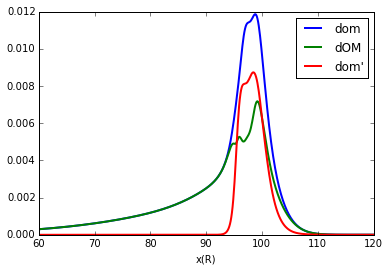

In [175]:
plt.plot(x.f[1:-1],cs_dom,label="dom",lw=2)
plt.plot(x.f[1:-1],cs_dOM,label="dOM",lw=2)
plt.plot(x.f[1:-1],cs_dom1,label="dom'",lw=2)
plt.xlim(60,120)
plt.xlabel("x(R)")
plt.legend()


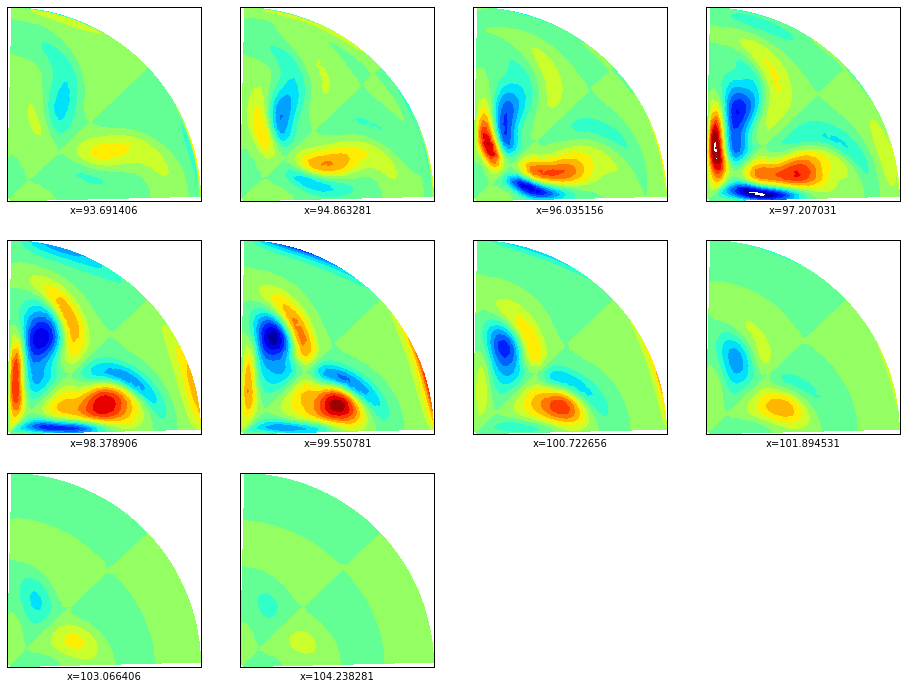

In [160]:
plt.figure(figsize=(16,16))
n=1
for ii in range(800,900,10):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dom[0,1:-1,1:-1,ii], (-0.035,0.035))
    plt.xlabel("x=%f" % x.f[ii])
    #pp.polar_arrow(velv[1,1:-1:3,1:-1:3,ii], velv[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], oxv[1:-1,1:-1,ii], -0.0005, 0.0005, 10)

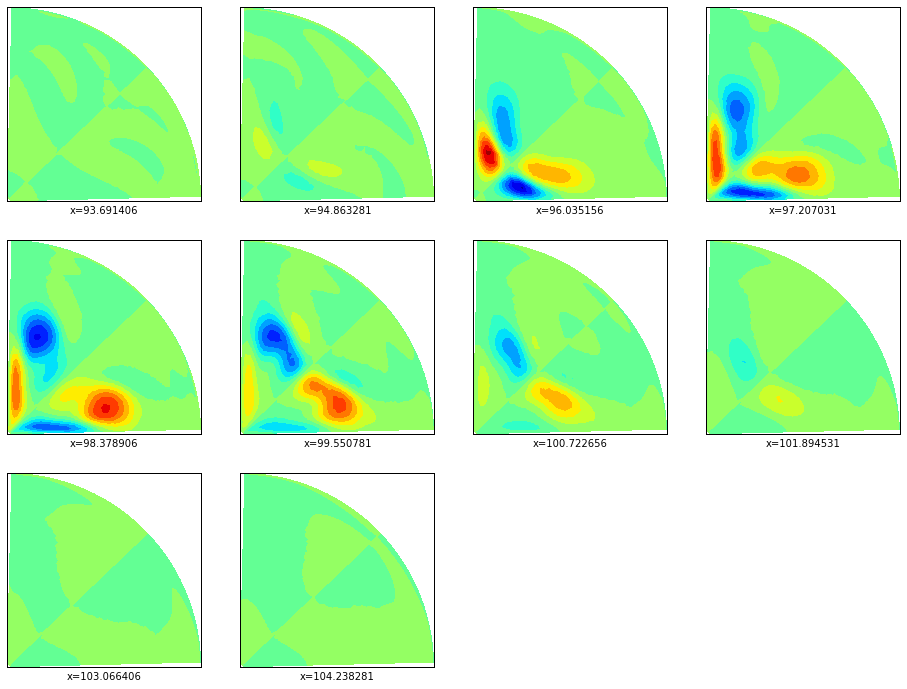

In [163]:
plt.figure(figsize=(16,16))
n=1
for ii in range(800,900,10):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dom1[0,1:-1,1:-1,ii], (-0.035,0.035))
    plt.xlabel("x=%f" % x.f[ii])
    #pp.polar_arrow(velv[1,1:-1:3,1:-1:3,ii], velv[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], oxv[1:-1,1:-1,ii], -0.0005, 0.0005, 10)

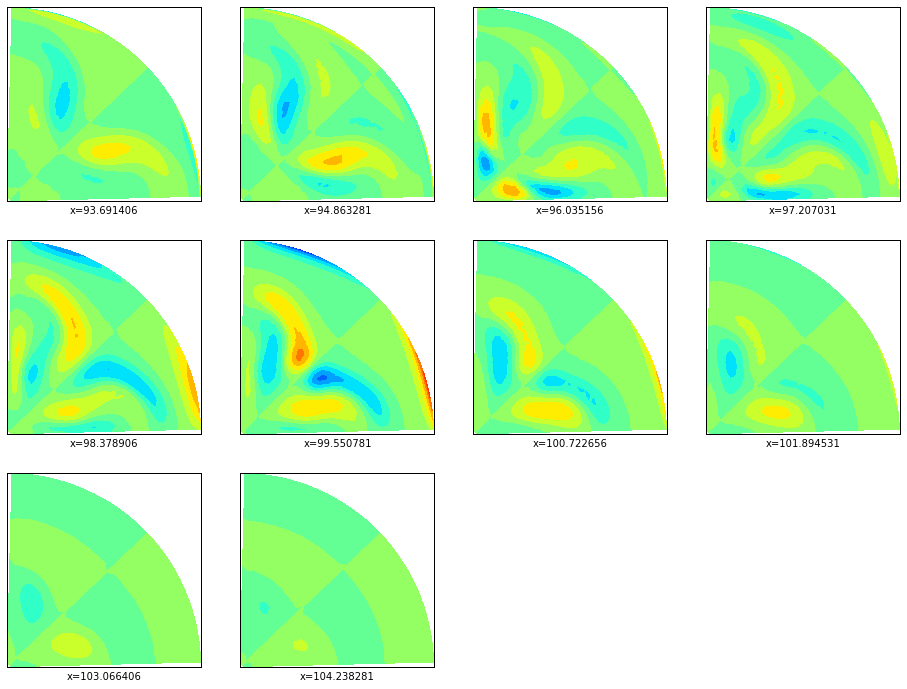

In [164]:
plt.figure(figsize=(16,16))
n=1
for ii in range(800,900,10):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dOM[0,1:-1,1:-1,ii], (-0.035,0.035))
    plt.xlabel("x=%f" % x.f[ii])
    #pp.polar_arrow(velv[1,1:-1:3,1:-1:3,ii], velv[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], oxv[1:-1,1:-1,ii], -0.0005, 0.0005, 10)

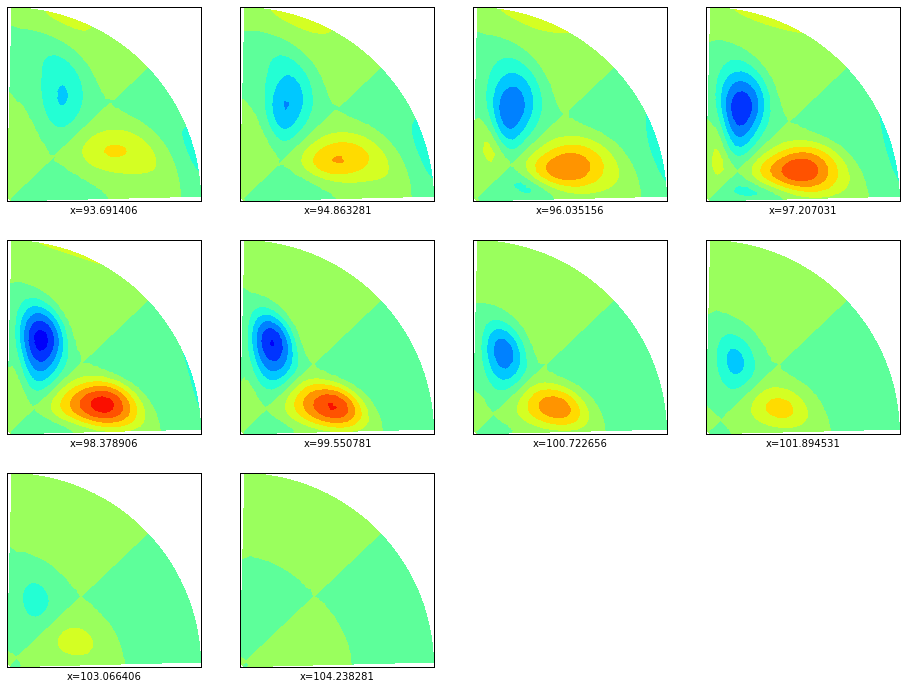

In [165]:
plt.figure(figsize=(16,16))
n=1
for ii in range(800,900,10):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], OM[0,1:-1,1:-1,ii], (-0.5,0.5))
    plt.xlabel("x=%f" % x.f[ii])
    #pp.polar_arrow(velv[1,1:-1:3,1:-1:3,ii], velv[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], oxv[1:-1,1:-1,ii], -0.0005, 0.0005, 10)

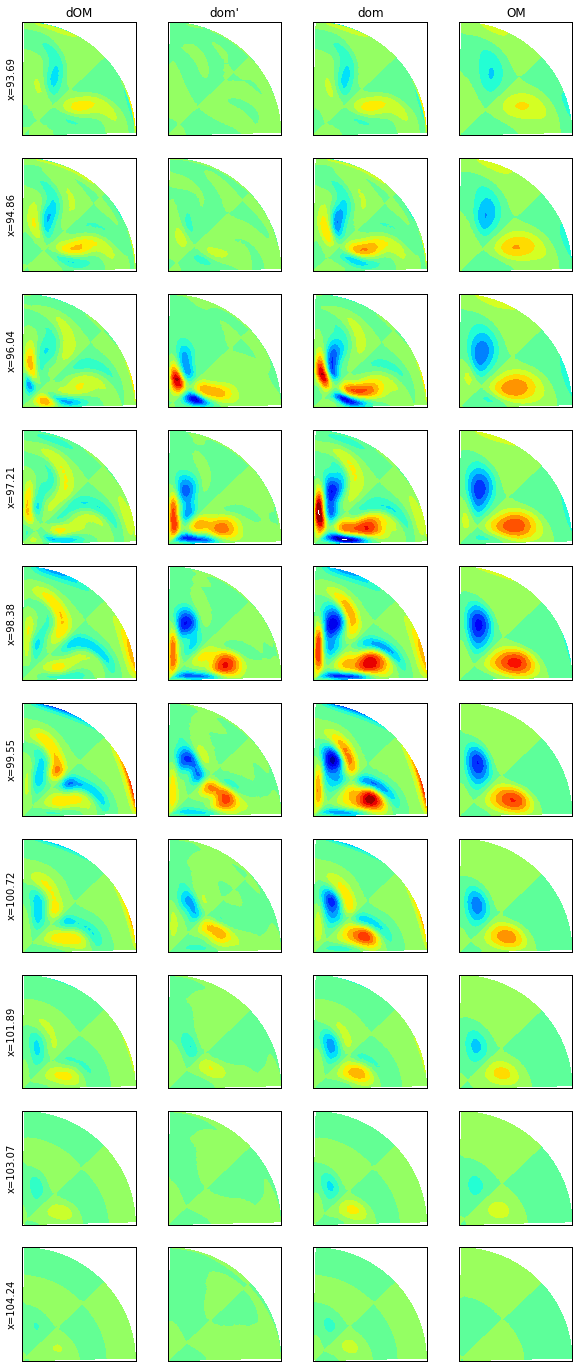

In [170]:
plt.figure(figsize=(10,24))
n=1
s = True
for ii in range(800,900,10):
    plt.subplot(10,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dOM[0,1:-1,1:-1,ii], (-0.035,0.035))
    #pp.polar_arrow(velv[1,1:-1:3,1:-1:3,ii], velv[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], oxv[1:-1,1:-1,ii], -0.0005, 0.0005, 10)
    plt.ylabel("x=%5.2f"%x.f[ii])
    if s:
        plt.title("dOM")
        
    
    plt.subplot(10,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dom1[0,1:-1,1:-1,ii], (-0.035,0.035))
    if s:
        plt.title("dom'")
    
    plt.subplot(10,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dom[0,1:-1,1:-1,ii], (-0.035,0.035))
    if s:
        plt.title("dom")
    
    plt.subplot(10,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], OM[0,1:-1,1:-1,ii], (-0.5,0.5))
    if s:
        plt.title("OM")
        s = False